In [1]:
import dataloader
import sys
import time
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import gc

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, RepeatVector
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, TimeDistributed

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

%load_ext autoreload
%autoreload 2

path = "../032721Comparison/Data/SONY2021.csv"
date = datetime.datetime(2021,3,12)
count = 1200
# We will use the previous 60 days as features
history_size = 60

In [2]:
# Compute MAE
def mae(y_hat, y):
    # mean absolute error
    return np.abs(y_hat - y).mean()

def rmse(y_hat, y):
    # root mean squared error
    return np.sqrt(np.mean(np.power((y-y_hat),2)))

In [3]:
df = dataloader.load_data_up_to_date(path, date, count)

(1258, 7)
(1257, 7)
(1257, 7)
(1200, 7)


In [4]:
sony_closing_all = df['Close'].to_numpy()
# reshape to 1200 x 1 matrix
sony_closing_all = np.reshape(sony_closing_all, (sony_closing_all.shape[0], -1))
sony_closing_all.shape

(1200, 1)

In [5]:
#converting prices to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sony_closing_all)
train = scaled_data[:1000,:]
test = scaled_data[1000:, :]

In [6]:
train_x, train_y = [], []
test_x, test_y = [], []
for i in range(history_size,len(train)):
    train_x.append(scaled_data[i-history_size:i,0])
    train_y.append(scaled_data[i,0])
train_x, train_y = np.array(train_x), np.array(train_y)

train_x = np.reshape(train_x, (train_x.shape[0],train_x.shape[1], 1))
print(train_x.shape)

for i in range(len(train),len(scaled_data)):
    test_x.append(scaled_data[i-history_size:i,0])
    test_y.append(scaled_data[i,0])
test_x, test_y = np.array(test_x), np.array(test_y)

test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1], 1))
print(test_x.shape)

(940, 60, 1)
(200, 60, 1)


In [7]:
# How many features do we want to pass as hidden unit
UNITS = range(30, 60, 5)
FILTERS = [2, 4, 8, 16, 32]
KERNELS = [2, 4, 8, 16]
K = 5
model = None
gc.collect()

best_config = None
# Best Validation Error
best_err = sys.maxsize

for filter_size in FILTERS:
    for kernel_size in KERNELS:
        for unit_count in UNITS:
            kf = KFold(n_splits=K, random_state=None, shuffle=False)
            y_err = []

            # Cross Validaiton
            for train_index, val_index in kf.split(train_x):
                X_train, X_val = train_x[train_index], train_x[val_index]
                y_train, y_val = train_y[train_index], train_y[val_index]

                model = Sequential()
                model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', input_shape=(train_x.shape[1],train_x.shape[2])))
                model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
                model.add(MaxPooling1D(pool_size=2))
                model.add(Flatten())
                model.add(RepeatVector(1))
                model.add(LSTM(units=unit_count, return_sequences=True))
                model.add(Flatten())
                model.add(Dense(unit_count))
                model.add(Dense(1))
                model.compile(loss='mean_squared_error', optimizer='adam')
                model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
                y_hat = model.predict(X_val).transpose()[0]
                del model
                gc.collect()

                y_err.append(rmse(y_hat, y_val))

            print(filter_size, kernel_size, unit_count, "mean val RMSE:", np.mean(y_err))

            if np.mean(y_err) < best_err:
                best_err = np.mean(y_err)
                best_config = (filter_size, kernel_size, unit_count)

print(best_config, best_err)

2 2 30 mean val RMSE: 0.02225496359239415
2 2 35 mean val RMSE: 0.07845191719763808
2 2 40 mean val RMSE: 0.06204499411644683
2 2 45 mean val RMSE: 0.0608500908952385
2 2 50 mean val RMSE: 0.06890256858771733
2 2 55 mean val RMSE: 0.07735329585616225
2 4 30 mean val RMSE: 0.06281120611171445
2 4 35 mean val RMSE: 0.06910197986949439
2 4 40 mean val RMSE: 0.121297797505084
2 4 45 mean val RMSE: 0.0894030137941024
2 4 50 mean val RMSE: 0.08115509494737935
2 4 55 mean val RMSE: 0.02767631490450222
2 8 30 mean val RMSE: 0.08493147943177455
2 8 35 mean val RMSE: 0.053134501854813464
2 8 40 mean val RMSE: 0.08218618282002534
2 8 45 mean val RMSE: 0.02921951433427413
2 8 50 mean val RMSE: 0.053327189872291604
2 8 55 mean val RMSE: 0.11490394916923201
2 16 30 mean val RMSE: 0.0896485977966944
2 16 35 mean val RMSE: 0.04279125662177137
2 16 40 mean val RMSE: 0.07156667639529356
2 16 45 mean val RMSE: 0.07475316330998254
2 16 50 mean val RMSE: 0.10667293069375632
2 16 55 mean val RMSE: 0.0731285

In [8]:
model = None
gc.collect()

model = Sequential()
model.add(Conv1D(filters=best_config[0], kernel_size=best_config[1], activation='relu', input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(Conv1D(filters=best_config[0], kernel_size=best_config[1], activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(1))
model.add(LSTM(units=best_config[2], return_sequences=True))
model.add(Flatten())
model.add(Dense(best_config[2]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=1000, batch_size=32, verbose=1)
print(model.summary())
y_hat = model.predict(test_x).transpose()[0]

del model
gc.collect()

Epoch 1/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 2/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 3/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 4/1000
30/30 [==============================] - 0s 2ms/step - loss: 9.2675e-04
Epoch 5/1000
30/30 [==============================] - 0s 3ms/step - loss: 7.1430e-04
Epoch 6/1000
30/30 [==============================] - 0s 3ms/step - loss: 5.8150e-04
Epoch 7/1000
30/30 [==============================] - 0s 5ms/step - loss: 4.9778e-04
Epoch 8/1000
30/30 [==============================] - 0s 6ms/step - loss: 4.6091e-04
Epoch 9/1000
30/30 [==============================] - 0s 6ms/step - loss: 4.3300e-04
Epoch 10/1000
30/30 [==============================] - 0s 6ms/step - loss: 3.6333e-04
Epoch 11/1000
30/30 [==============================] - 0s 6ms/step - loss: 3.6520e-04
Epoch 12/1000
30/30 [==============================] - 0s 6ms/step - loss: 

30/30 [==============================] - 0s 3ms/step - loss: 1.6454e-04
Epoch 191/1000
30/30 [==============================] - 0s 3ms/step - loss: 1.0380e-04
Epoch 192/1000
30/30 [==============================] - 0s 6ms/step - loss: 9.5090e-05
Epoch 193/1000
30/30 [==============================] - 0s 6ms/step - loss: 1.0397e-04
Epoch 194/1000
30/30 [==============================] - 0s 6ms/step - loss: 1.0102e-04
Epoch 195/1000
30/30 [==============================] - 0s 7ms/step - loss: 1.0652e-04
Epoch 196/1000
30/30 [==============================] - 0s 7ms/step - loss: 9.8483e-05
Epoch 197/1000
30/30 [==============================] - 0s 7ms/step - loss: 1.0721e-04
Epoch 198/1000
30/30 [==============================] - 0s 7ms/step - loss: 1.1295e-04
Epoch 199/1000
30/30 [==============================] - 0s 7ms/step - loss: 9.8627e-05
Epoch 200/1000
30/30 [==============================] - 0s 7ms/step - loss: 1.0700e-04
Epoch 201/1000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 6ms/step - loss: 7.1359e-05
Epoch 379/1000
30/30 [==============================] - 0s 6ms/step - loss: 7.9093e-05
Epoch 380/1000
30/30 [==============================] - 0s 6ms/step - loss: 1.1389e-04
Epoch 381/1000
30/30 [==============================] - 0s 6ms/step - loss: 9.0652e-05
Epoch 382/1000
30/30 [==============================] - 0s 7ms/step - loss: 7.9931e-05
Epoch 383/1000
30/30 [==============================] - 0s 6ms/step - loss: 8.1164e-05
Epoch 384/1000
30/30 [==============================] - 0s 6ms/step - loss: 8.6141e-05
Epoch 385/1000
30/30 [==============================] - 0s 6ms/step - loss: 8.7627e-05
Epoch 386/1000
30/30 [==============================] - 0s 6ms/step - loss: 9.9049e-05
Epoch 387/1000
30/30 [==============================] - 0s 6ms/step - loss: 8.3513e-05
Epoch 388/1000
30/30 [==============================] - 0s 6ms/step - loss: 7.2880e-05
Epoch 389/1000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 7ms/step - loss: 5.2494e-05
Epoch 567/1000
30/30 [==============================] - 0s 7ms/step - loss: 4.7957e-05
Epoch 568/1000
30/30 [==============================] - 0s 7ms/step - loss: 4.8161e-05
Epoch 569/1000
30/30 [==============================] - 0s 7ms/step - loss: 5.5139e-05
Epoch 570/1000
30/30 [==============================] - 0s 7ms/step - loss: 5.4390e-05
Epoch 571/1000
30/30 [==============================] - 0s 7ms/step - loss: 4.7410e-05
Epoch 572/1000
30/30 [==============================] - 0s 7ms/step - loss: 4.9607e-05
Epoch 573/1000
30/30 [==============================] - 0s 7ms/step - loss: 6.2717e-05
Epoch 574/1000
30/30 [==============================] - 0s 7ms/step - loss: 5.4218e-05
Epoch 575/1000
30/30 [==============================] - 0s 7ms/step - loss: 4.9380e-05
Epoch 576/1000
30/30 [==============================] - 0s 7ms/step - loss: 5.3353e-05
Epoch 577/1000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 5ms/step - loss: 4.8254e-05
Epoch 755/1000
30/30 [==============================] - 0s 5ms/step - loss: 4.6098e-05
Epoch 756/1000
30/30 [==============================] - 0s 5ms/step - loss: 3.5646e-05
Epoch 757/1000
30/30 [==============================] - 0s 5ms/step - loss: 3.9476e-05
Epoch 758/1000
30/30 [==============================] - 0s 5ms/step - loss: 3.5990e-05
Epoch 759/1000
30/30 [==============================] - 0s 5ms/step - loss: 3.1475e-05
Epoch 760/1000
30/30 [==============================] - 0s 5ms/step - loss: 3.8186e-05
Epoch 761/1000
30/30 [==============================] - 0s 5ms/step - loss: 3.7600e-05
Epoch 762/1000
30/30 [==============================] - 0s 5ms/step - loss: 2.9649e-05
Epoch 763/1000
30/30 [==============================] - 0s 5ms/step - loss: 2.9745e-05
Epoch 764/1000
30/30 [==============================] - 0s 5ms/step - loss: 3.2308e-05
Epoch 765/1000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 7ms/step - loss: 2.1599e-05
Epoch 943/1000
30/30 [==============================] - 0s 7ms/step - loss: 1.9296e-05
Epoch 944/1000
30/30 [==============================] - 0s 7ms/step - loss: 1.9881e-05
Epoch 945/1000
30/30 [==============================] - 0s 7ms/step - loss: 1.9031e-05
Epoch 946/1000
30/30 [==============================] - 0s 7ms/step - loss: 1.9083e-05
Epoch 947/1000
30/30 [==============================] - 0s 7ms/step - loss: 2.3121e-05
Epoch 948/1000
30/30 [==============================] - 0s 7ms/step - loss: 2.4203e-05
Epoch 949/1000
30/30 [==============================] - 0s 7ms/step - loss: 1.8874e-05
Epoch 950/1000
30/30 [==============================] - 0s 7ms/step - loss: 1.8926e-05
Epoch 951/1000
30/30 [==============================] - 0s 7ms/step - loss: 2.3067e-05
Epoch 952/1000
30/30 [==============================] - 0s 7ms/step - loss: 2.6187e-05
Epoch 953/1000
30/30 [==============================] - 0s

20723

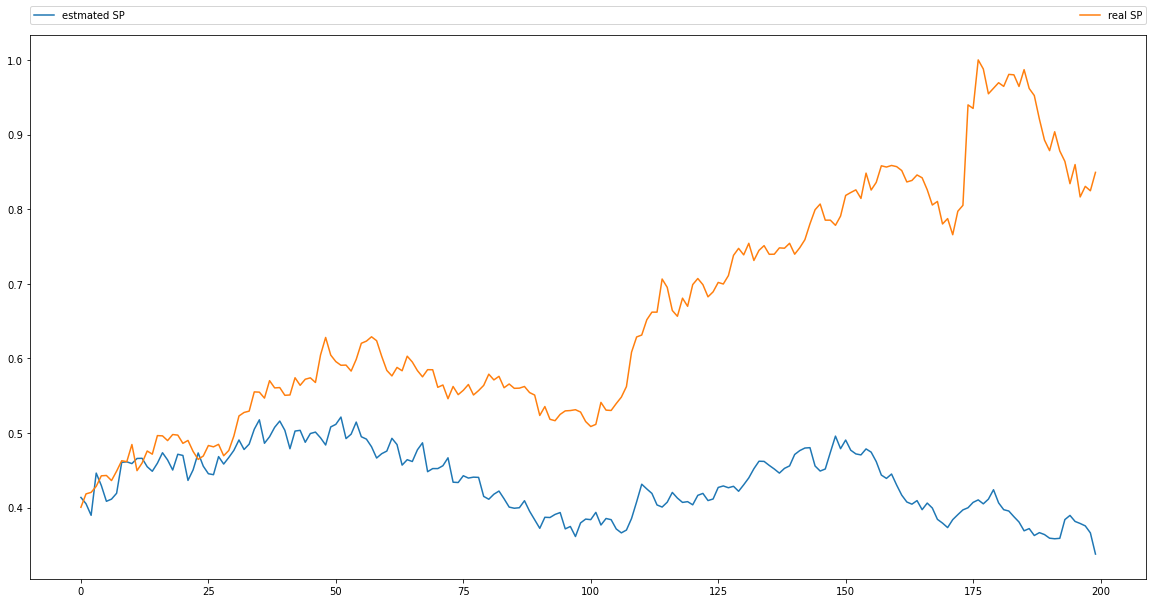

In [9]:
plt.plot(y_hat[:], label="estmated SP")
plt.plot(test_y[:], label="real SP")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [10]:
print("MAE:  ", mae(y_hat, test_y))
print("RMSE: ", rmse(y_hat, test_y))

MAE:   0.22526926111194928
RMSE:  0.282673820716344
